In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim=128):
        super(NerfModel, self).__init__()

        self.block1 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), )
        # density estimation
        self.block2 = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + hidden_dim + 3, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1), )
        # color estimation
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2), nn.ReLU(), )
        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(o, self.embedding_dim_pos)
        emb_d = self.positional_encoding(d, self.embedding_dim_direction)
        h = self.block1(emb_x)
        tmp = self.block2(torch.cat((h, emb_x), dim=1))
        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1])
        h = self.block3(torch.cat((h, emb_d), dim=1))
        c = self.block4(h)
        return c, sigma


model = NerfModel(hidden_dim=256).cuda()
model.load_state_dict(torch.load('nerf.pt'))
model.eval()

NerfModel(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=257, bias=True)
  )
  (block3): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
  )
  (block4): Sequential(
    (0): Linear(in_features=128, out_features=3, bias=True)
    (1): Sigmoid()
  )
  (relu): ReLU()
)

In [3]:
@torch.no_grad()
def test(dataset, model, hn, hf, chunk_size=10, img_index=0, nb_bins=192, H=400, W=400):
    """
    Args:
        hn: near plane distance
        hf: far plane distance
        dataset: dataset to render
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        img_index (int, optional): image index to render. Defaults to 0.
        nb_bins (int, optional): number of bins for density estimation. Defaults to 192.
        H (int, optional): image height. Defaults to 400.
        W (int, optional): image width. Defaults to 400.

    Returns:
        None: None
    """

    device = 'cuda'

    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    data = []
    for i in range(int(np.ceil(H / chunk_size))):

        ray_origins_ = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_directions_ = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        regenerated_px_values = render_rays(model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins)
        data.append(regenerated_px_values)
    img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)
    plt.figure()
    plt.imshow(img)
    plt.savefig(f'img_{img_index}.png', bbox_inches='tight')
    plt.close()



In [4]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

#This is the only part in the assignment that you'll need to fill in. You are advised to not change any other part of the code.

In [5]:
def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):
    ## FILL IN YOUR CODE HERE
    device = ray_origins.device

    # Equation: r(t) = o+td -> Building the "t" here.
    t = torch.linspace(hn, hf, nb_bins, device=device)
    t = t.expand(ray_origins.shape[0], nb_bins)
    
    # add noise
    midpos = (t[:, :-1] + t[:, 1:]) / 2.
    low = torch.cat((t[:, :1], midpos), -1)
    noise = torch.rand(t.shape, device=device)
    t = low + ((hf - hf)/nb_bins) * noise  # t: [batch_size, nb_bins]
    epsilon = 1e10
    epsilon = torch.tensor([epsilon], device=device).expand(ray_origins.shape[0], 1)
    delta = t[:, 1:] - t[:, :-1]
    delta  = torch.cat((delta, epsilon), -1)
    
    # Equation: r(t) = o+td -> Building the "r" here.
    r = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)   # x: [batch_size, nb_bins, 3]
    
    # Expand shape 
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1) 

    origin = r.reshape(-1, 3)
    direction =  ray_directions.reshape(-1, 3)
    # predict rgb and sigma using the model
    rgb, sigma = nerf_model(origin,  direction)
    rgb = rgb.reshape(r.shape)
    sigma = sigma.reshape(r.shape[:-1])

    # Compute alpha 
    alpha = 1 - torch.exp(-sigma * delta)  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha)
    weights = weights.unsqueeze(2) * alpha.unsqueeze(2)
    
    # Compute the pixel values as a weighted sum of colors along each ray
    c = (weights * rgb).sum(dim=1)
    dims = len(weights.shape)
    accum_weight = weights.sum(dim=dims-1).sum(dim = dims -2)
    
    # Regularization for white background 
    return c + 1 - accum_weight.unsqueeze(-1)

In [6]:
import numpy as np

# Load the data using a different approach to check for possible issues
try:
    data = np.load('test_data.npy', allow_pickle=True)
    print(f"Data loaded successfully. Shape of the loaded data: {data.shape}")
except ValueError as e:
    print(f"Error loading data: {e}")
    with open('test_data.npy', 'rb') as f:
        # Read the header of the .npy file to inspect its metadata
        version = np.lib.format.read_magic(f)
        print(f"NPY file version: {version}")
        shape, fortran_order, dtype = np.lib.format._read_array_header(f, version)
        print(f"Shape from header: {shape}")
        print(f"Fortran order: {fortran_order}")
        print(f"Data type: {dtype}")

        # Try loading a portion of the data
        f.seek(0)
        data_portion = np.frombuffer(f.read(), dtype=dtype)
        print(f"Loaded a portion of the data: {data_portion[:100]}")  # Displaying the first 100 elements


Data loaded successfully. Shape of the loaded data: (8000000, 9)


In [7]:
import torch
import numpy as np

# Load the data
data = np.load('test_data.npy', allow_pickle=True)
print(f"Data loaded successfully. Shape of the loaded data: {data.shape}")

# Convert the numpy array to a torch tensor
testing_dataset = torch.from_numpy(data)

print(f"Shape of the tensor: {testing_dataset.shape}")


Data loaded successfully. Shape of the loaded data: (8000000, 9)
Shape of the tensor: torch.Size([8000000, 9])


In [8]:
testing_dataset = torch.from_numpy(np.load('test_data.npy', allow_pickle=True))

In [9]:
for img_index in range(50):
  test(testing_dataset, model, hn=2, hf=6, img_index=img_index, nb_bins=192, H=400, W=400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

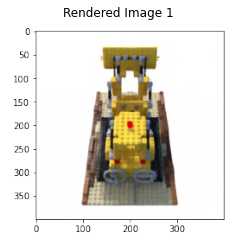

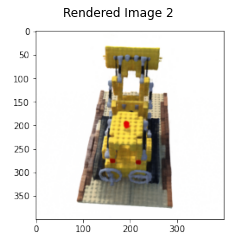

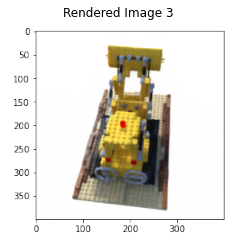

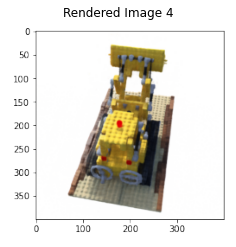

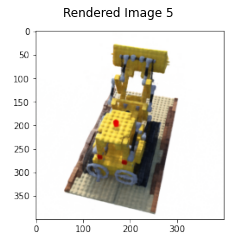

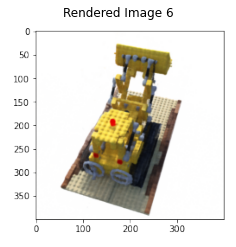

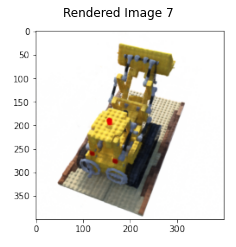

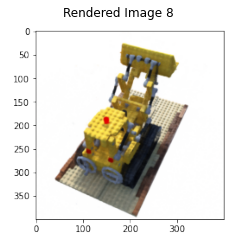

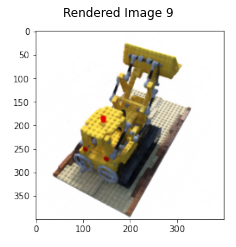

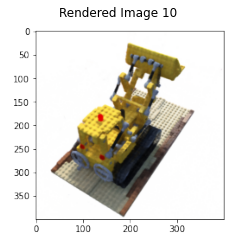

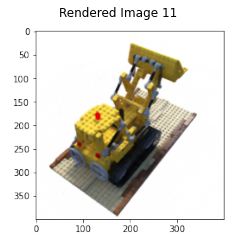

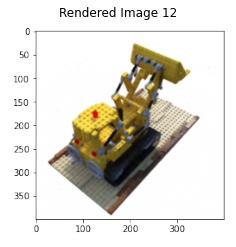

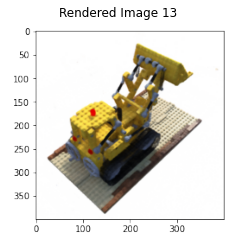

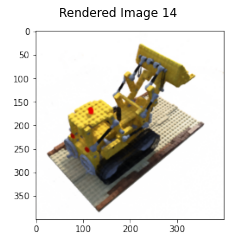

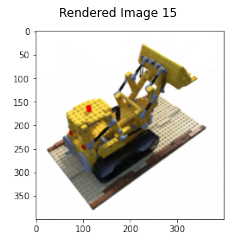

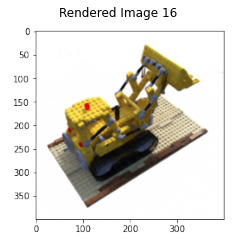

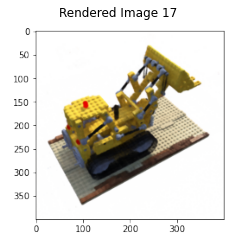

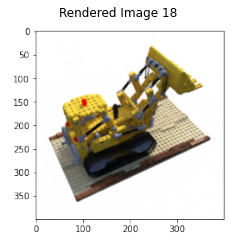

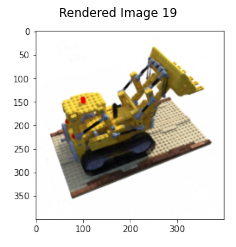

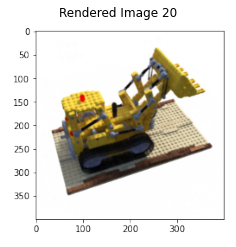

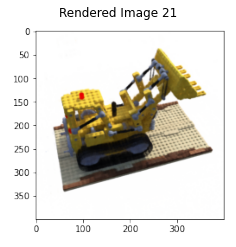

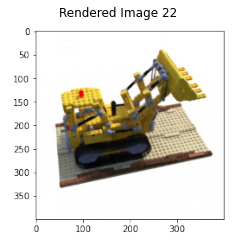

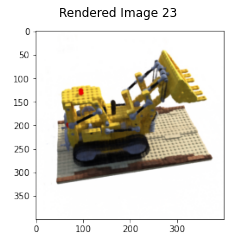

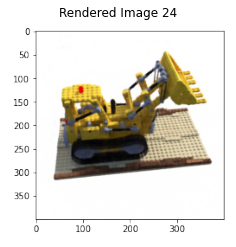

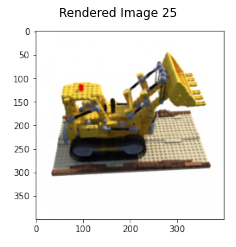

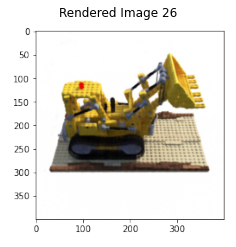

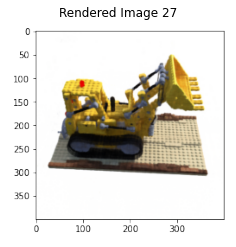

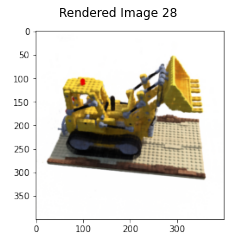

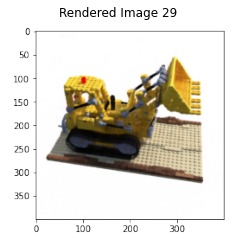

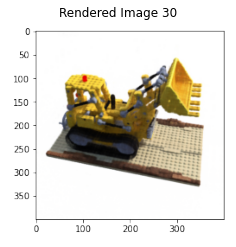

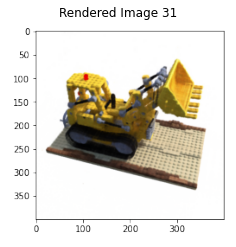

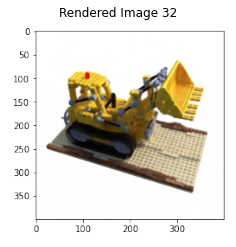

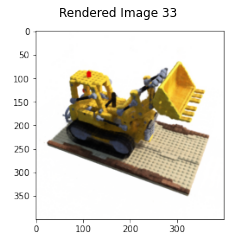

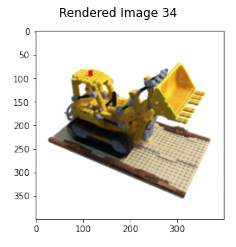

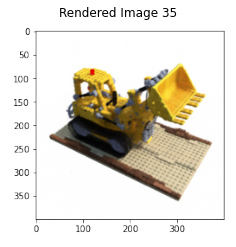

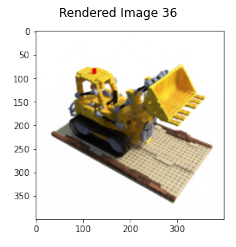

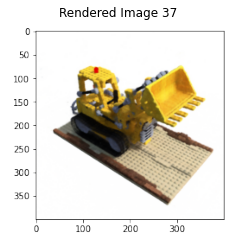

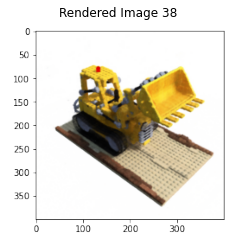

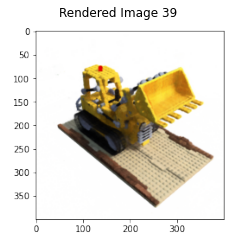

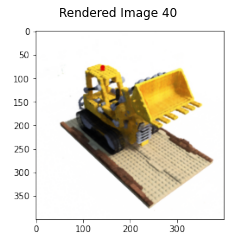

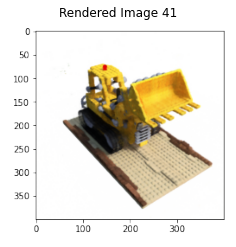

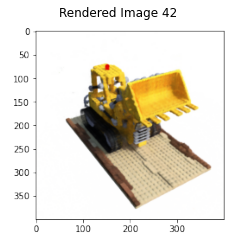

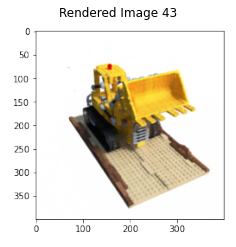

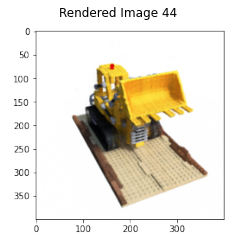

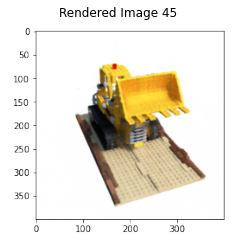

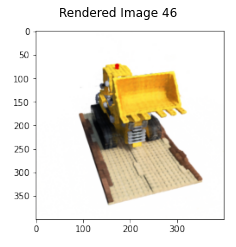

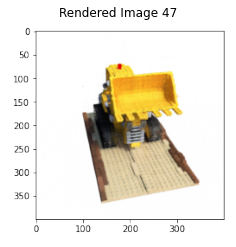

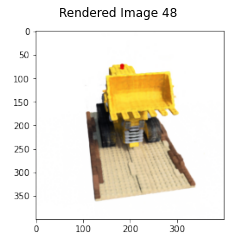

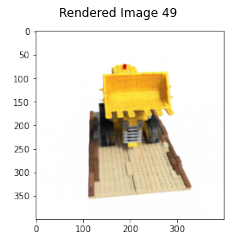

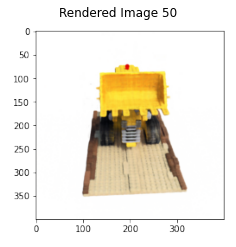

In [10]:
from PIL import Image

# Test and save images
# for img_index in range(2):  # Limited to first 2 images
#     test(testing_dataset, model, hn=2, hf=6, img_index=img_index, nb_bins=192, H=400, W=400)

# Load and display a couple of saved images
for i in range(50):  # Display all 50 images 
    img_path = f'img_{i}.png'
    img = Image.open(img_path)
    plt.figure()
    plt.imshow(img)
    plt.title(f'Rendered Image {i+1}')
    plt.axis('off')  # Hide the axis
    plt.show()